In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 
import torch
import cv2
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from Dataloader import JetcarDataset, SimulatorDataset

In [3]:
transforms = torch.nn.Sequential(
    T.RandomResizedCrop(size=(240, 320),scale=(0.5,1)),
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 4)),
    T.ColorJitter(brightness=.3, hue=.3, saturation=.3),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
)

In [4]:
simData = SimulatorDataset("simulator_data/driving_log.csv", "simulator_data/IMG", transform=transforms)
x,y = simData[0]
x.shape

(3, 240, 320)

In [5]:
simData[0]

(array([[[ 0.57208526,  0.57258284,  0.57572377, ...,  0.49085188,
           0.49085188,  0.49085188],
         [ 0.57806087,  0.5773965 ,  0.57325137, ...,  0.49086487,
           0.49086487,  0.49086487],
         [ 0.58598065,  0.58643055,  0.5892441 , ...,  0.4908818 ,
           0.4908818 ,  0.4908818 ],
         ...,
         [ 0.8421333 ,  0.84119225,  0.8379221 , ..., -0.03754449,
           0.0078752 ,  0.03980219],
         [ 0.7840874 ,  0.78275216,  0.7701156 , ..., -0.0621109 ,
          -0.05479175, -0.03866422],
         [ 0.6558676 ,  0.6485244 ,  0.6173233 , ..., -0.04350007,
          -0.06904006, -0.07151592]],
 
        [[ 0.30393898,  0.30376732,  0.30268157, ...,  0.35108876,
           0.35108876,  0.35108876],
         [ 0.30187368,  0.3021034 ,  0.30353618, ...,  0.3450899 ,
           0.3450899 ,  0.3450899 ],
         [ 0.29913676,  0.29898143,  0.29800892, ...,  0.3373227 ,
           0.3373227 ,  0.3373227 ],
         ...,
         [ 0.07633328,  0.0795062

In [6]:
y.shape

(2,)

In [7]:
y.reshape(-1, 2).shape

(1, 2)

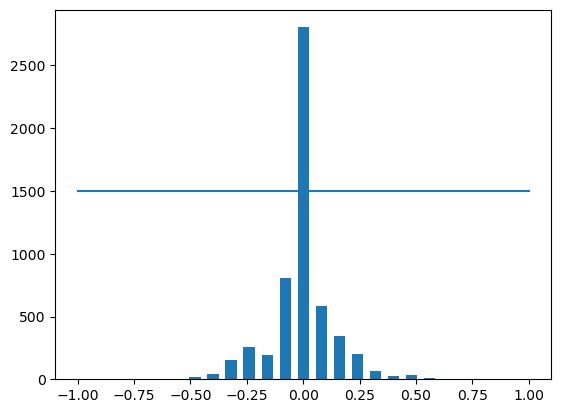

In [7]:
simData.plot_hist()

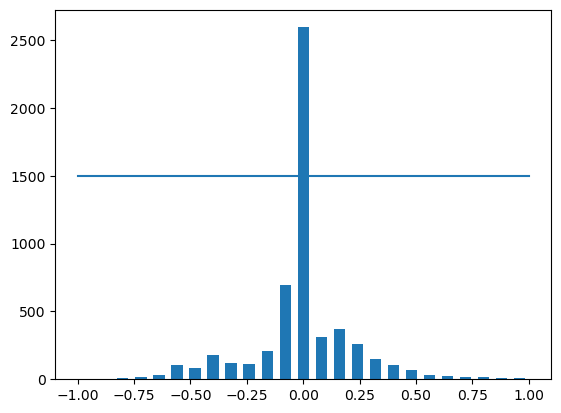

In [6]:
simData.set_gain(1.7)
#simData.balance_data()
simData.plot_hist()

In [7]:
simData = simData

In [9]:
simData.__len__()

5537

/Users/sudu/files/jetcar/mac_training/dataloader.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return image.permute(1, 2, 0), torch.tensor([label])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


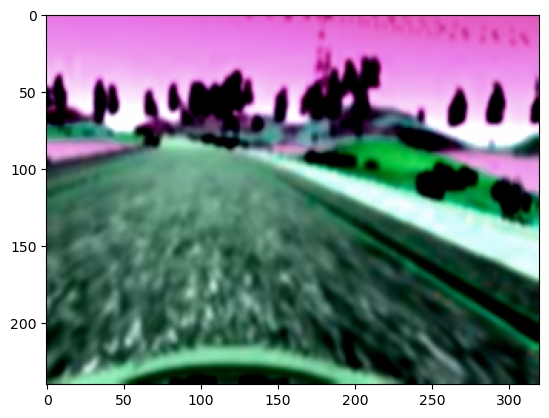

In [8]:
x,y = simData.get_rgb(9)
plt.imshow(np.array(x))

In [9]:
train_generator = DataLoader(simData, batch_size=4, shuffle=True)
#test_generator = DataLoader(simData[])

In [9]:
x,y = next(iter(train_generator))
x.shape

torch.Size([4, 3, 240, 320])

In [10]:
y

tensor([[0.0000, 1.0000],
        [0.0000, 1.0000],
        [0.0000, 1.0000],
        [0.2421, 1.0000]])

In [11]:
y[0]

tensor([0., 1.])

In [10]:
class NetworkNvidia(nn.Module):
    """NVIDIA model used in the paper."""

    def __init__(self):
        """Initialize NVIDIA model.
        NVIDIA model used
            Image normalization to avoid saturation and make gradients work better.
            Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Drop out (0.5)
            Fully connected: neurons: 100, activation: ELU
            Fully connected: neurons: 50, activation: ELU
            Fully connected: neurons: 10, activation: ELU
            Fully connected: neurons: 1 (output)
        the convolution layers are meant to handle feature engineering.
        the fully connected layer for predicting the steering angle.
        the elu activation function is for taking care of vanishing gradient problem.
        """
        super(NetworkNvidia, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=48576, out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=2)
        )

    def forward(self, input):
        """Forward pass."""
        input = input.view(input.size(0), 3, 240, 320)
        output = self.conv_layers(input)
        # print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output


class LeNet(nn.Module):
    """LeNet architecture."""

    def __init__(self):
        """Initialization."""
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(70224, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 2)

    def forward(self, x):
        """Forward pass."""
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [19]:
#device = torch.device('cuda')
output_dim = 2 

# ALEXNET
# model = torchvision.models.alexnet(pretrained=True)
# model.classifier[-1] = torch.nn.Linear(4096, output_dim)

# SQUEEZENET 
# model = torchvision.models.squeezenet1_1(pretrained=True)
# model.classifier[1] = torch.nn.Conv2d(512, output_dim, kernel_size=1)
# model.num_classes = len(dataset.categories)

# RESNET 18
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, output_dim)

# RESNET 34
# model = torchvision.models.resnet34(pretrained=True)
# model.fc = torch.nn.Linear(512, output_dim)

# DENSENET 121
# model = torchvision.models.densenet121(pretrained=True)
# model.classifier = torch.nn.Linear(model.num_features, output_dim)

#model = model.to(device)

/opt/homebrew/Caskroom/miniforge/base/envs/jetracer_mac/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/jetracer_mac/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model = NetworkNvidia()

In [12]:
print(model)

NetworkNvidia(
  (conv_layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
    (1): ELU(alpha=1.0)
    (2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
    (3): ELU(alpha=1.0)
    (4): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=48576, out_features=100, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [13]:
criterion = nn.L1Loss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
device = torch.device("mps")

In [15]:
from Trainer import train_model

In [16]:
model, train_loss, test_loss = train_model(20,model,train_generator,None,criterion,optimizer, device=device)

/opt/homebrew/Caskroom/miniforge/base/envs/jetracer_mac/lib/python3.8/site-packages/torch/autograd/__init__.py:197: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1/20 	Train Loss: 0.025190
Test loss decreased (inf --> 0.025190. Saving model...
Epoch: 2/20 	Train Loss: 0.212098
Epoch: 3/20 	Train Loss: 0.020112
Test loss decreased (0.025190 --> 0.020112. Saving model...
Epoch: 4/20 	Train Loss: 0.020309
Epoch: 5/20 	Train Loss: 0.020333
Epoch: 6/20 	Train Loss: 0.020593
Epoch: 7/20 	Train Loss: 0.021010
Epoch: 8/20 	Train Loss: 0.021003
Epoch: 9/20 	Train Loss: 0.021401
Epoch: 10/20 	Train Loss: 0.022403
Epoch: 11/20 	Train Loss: 0.021074
Epoch: 12/20 	Train Loss: 0.020946
Epoch: 13/20 	Train Loss: 0.020894
Epoch: 14/20 	Train Loss: 0.020958
Epoch: 15/20 	Train Loss: 0.020835
Epoch: 16/20 	Train Loss: 0.020830
Epoch: 17/20 	Train Loss: 0.020858
Epoch: 18/20 	Train Loss: 0.020591
Epoch: 19/20 	Train Loss: 0.020700
Epoch: 20/20 	Train Loss: 0.020541
Time elapsed: 0.7037430971860885 hours


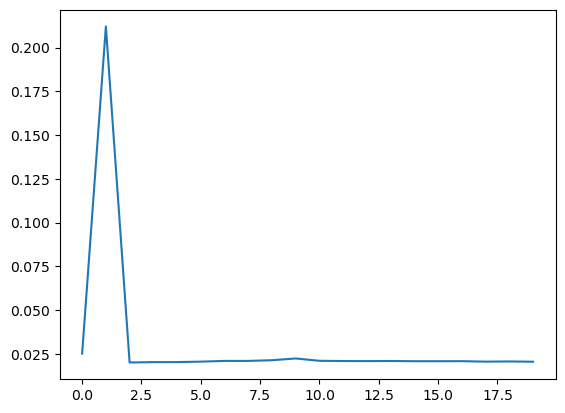

In [17]:
plt.plot(train_loss)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


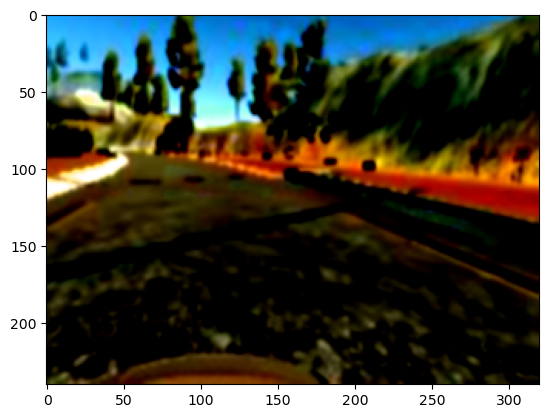

In [58]:
x,y = simData.get_rgb(4200)
plt.imshow(x)

In [75]:
x,y = next(iter(train_generator))

In [76]:
out = model(x.to(device))

In [77]:
out

tensor([[0.0117, 0.9760],
        [0.0117, 0.9760],
        [0.0117, 0.9760],
        [0.0117, 0.9760]], device='mps:0', grad_fn=<LinearBackward0>)